In [1]:
import numpy as np
from matplotlib.pyplot import *
from jupyterthemes import jtplot
%matplotlib inline
jtplot.style(theme='oceans16', context='notebook', ticks=True)

## Time-dependant nucleation

The goal of this experiment is to see if we can simulate the depletion of the H2O gas phase. To do that, we calculate both the nucleaation rate (number of new clusters per unit volume each second), and the number of molecules in a new cluster ($i^*$, size of the critical cluster in Seinfeld).

Since we have both these numbers, we know how many molecules were "taken" from the gas phase for each time frame, and we can compute a new $p_{\text{H}_{2}\text{O}}$ for the next step.

*One potential issue is that nucleation releases enegery as latent heat, which changes the ambiant temperature. This does not account for that.*

In [2]:
sigma = 72e-3 # Converted into SI
m1 = 2.99e-23 * 1e-3 # Converted into SI
v1 = 2.99e-23 * 1e-6 # converted into SI
kb = 1.38e-23

# Tetens equation
# https://en.wikipedia.org/wiki/Vapour_pressure_of_water
def p_sat(t):
    t -= 273
    return 610.78 * np.exp((17.27 * t) / (237.3 + t))

## Size of the critical cluster (number of molecules in a single droplet)

In [9]:
def cluster(t, p_h2o):
    S = p_h2o / p_sat(t)
    return (32.0 * np.pi / 3.0) \
         * ((v1**2.0) * (sigma ** 3.0))/(((kb * t)**3.0) * (np.log(S)**3.0))

def nucleate(t, p_h2o):
    N = p_h2o / kb * t
    S = p_h2o / p_sat(t)
    inside = - (16.0 * np.pi / 3.0) \
             * (v1**2.0 * sigma**3.0) / (((kb*t)**3.0) * (np.log(S)**2.0))
    return np.sqrt(2.0 * sigma / np.pi * m1) \
         * (v1 * (N**2.0) / S) \
         * np.exp(inside)

In [4]:
t = 293
S = np.linspace(2, 5)
p_h2o = S * p_sat(t)

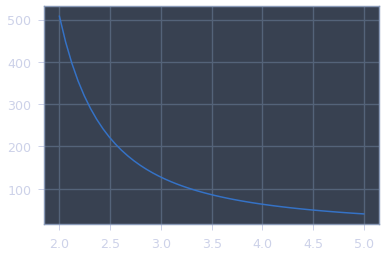

In [7]:
i_s = cluster(t, p_h2o)
plot(S, i_s)

This curve is consistent with the table pp.502;503;506 of Seinfeld. This gives us the cluster size above which we see nucleation.

2338.2047063802643


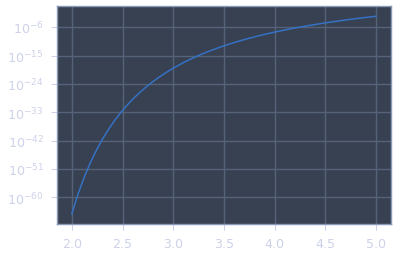

In [8]:
J = nucleate(t, p_h2o)
semilogy(S, J * 1e-6)
print(p_sat(t))